# Librerías

In [122]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
import h5py
import torch
import pickle 
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from preprocess import read_dataset, normalize

In [145]:
import utils 

In [124]:
import warnings
warnings.filterwarnings(action='ignore')

# Lectura de datos

In [125]:
data_file = 'data/Small_Datasets/HumanLiver_counts_top5000.h5'

# Lectura de datos
data_mat = h5py.File(data_file)
x = np.array(data_mat['X'])
y = np.array(data_mat['Y'])
data_mat.close()

# preprocesamiento scRNA-seq read counts matrix
adata = sc.AnnData(x)
adata.obs['Group'] = y

adata = read_dataset(adata,
                    transpose=False,
                    test_split=False,
                    copy=True)

adata = normalize(adata,
                    size_factors=True,
                    normalize_input=True,
                    logtrans_input=True)

input_size = adata.n_vars

### Autoencoder: Successfully preprocessed 5000 genes and 8444 cells.


In [126]:
with open('results/pruebasNAN/HumanLiver/pretrained_model_with_299_epochs.pickle', 'rb') as f:
    nn = pickle.load(f)
    print('### Se leyó el modelo pre-entrenado')

### Se leyó el modelo pre-entrenado


# Datos iniciales - Antes del fit

In [127]:
nn.mu.shape 

torch.Size([8, 32])

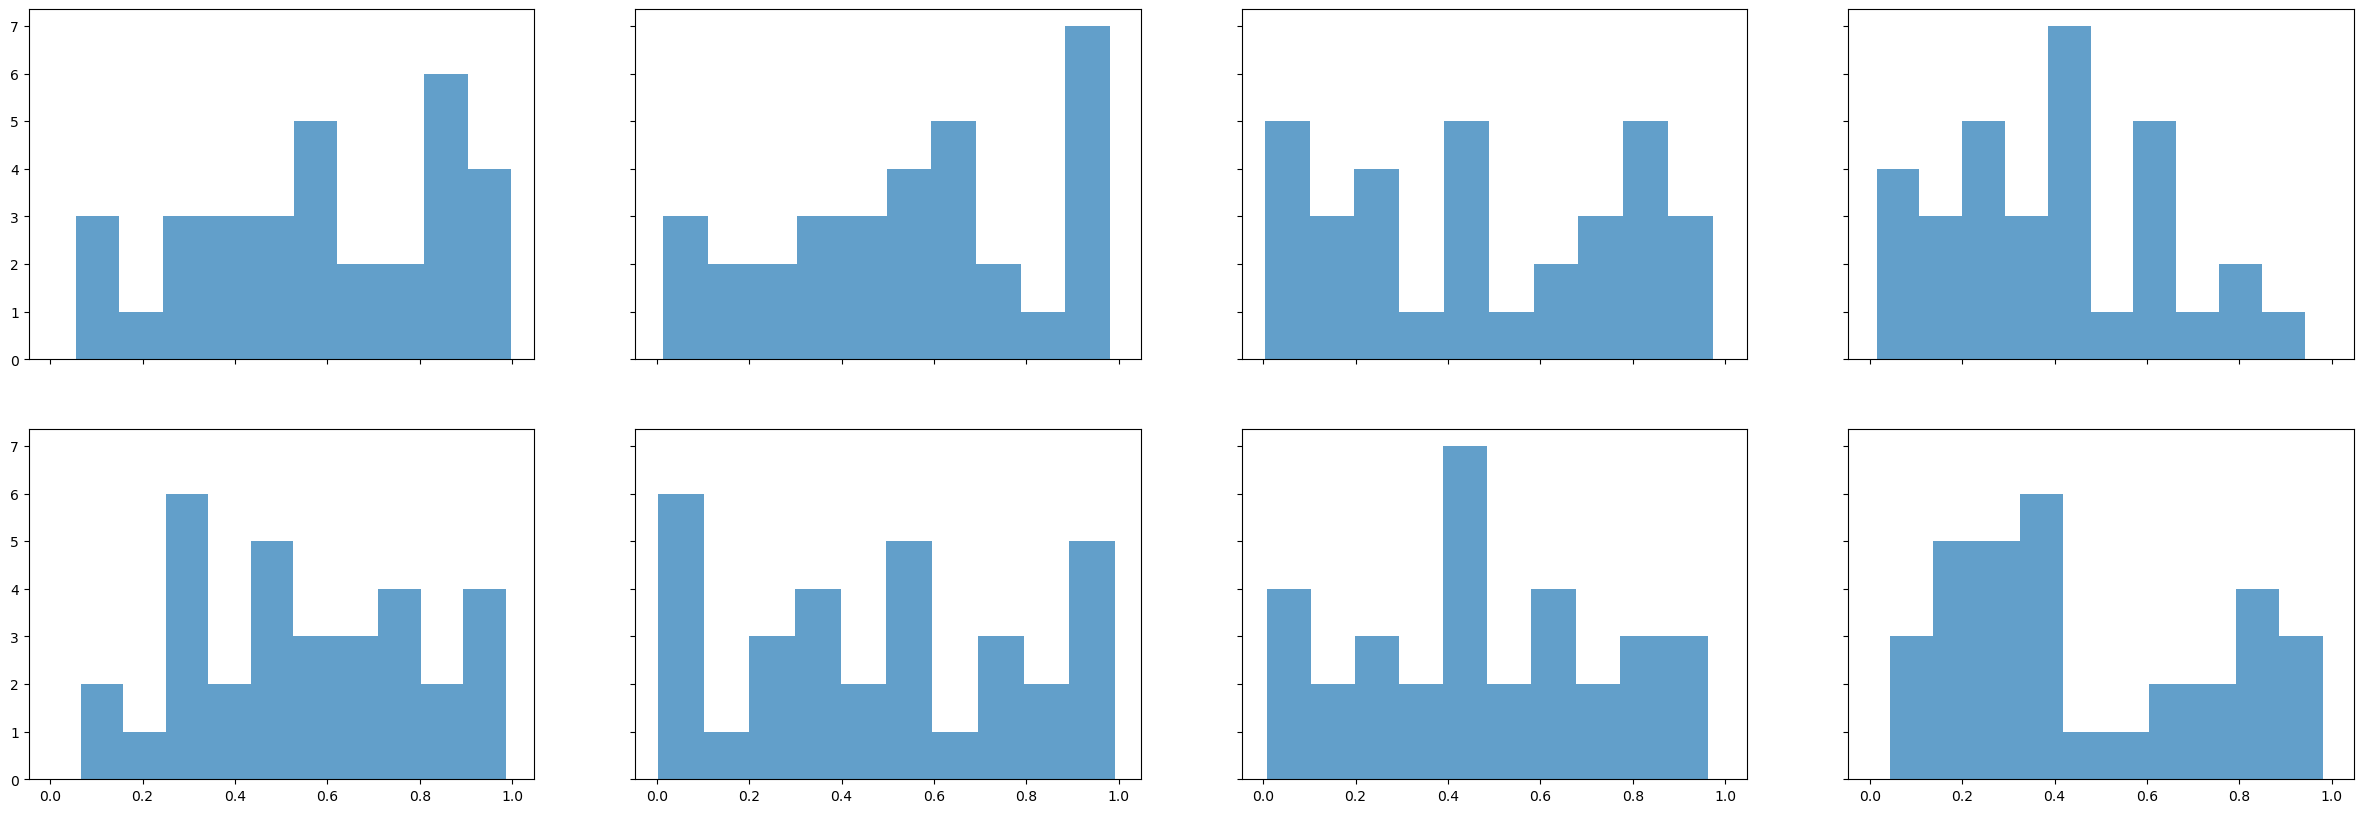

In [128]:
fig, axes = plt.subplots(nrows=2, ncols = 4, figsize = (30,10), sharex = True, sharey = True)
for r in range(2):
    for c in range(4):
        axes[r][c].hist(nn.mu.detach().numpy()[r*4 + c], alpha = 0.7) 

# Fit

In [129]:
# import torch
# x = torch.tensor([1., 2.])
# x.grad = torch.tensor([0.4, float("inf")])
# torch.nn.utils.clip_grad_value_(x, 5)
# print(x.grad)

In [141]:
forw = nn.forward(torch.Tensor(x))[0]

In [146]:
model = KMeans(n_clusters = 11)
model.fit(forw.detach().numpy())

utils.cluster_acc(y, model.predict(forw.detach().numpy()))


0.37269066792989103

In [ ]:
num_epochs = 150
lr = 0.001

# Segundo entrenamiento: clustering loss + ZINB loss
y_pred,  mu, pi, cov, z, epochs, clustering_metrics, clustering_metrics_id, losses = nn.fit(X=adata.X, X_raw=adata.raw.X, sf=adata.obs.size_factors,  
                                batch_size = 256,  num_epochs = num_epochs, update_interval = 1, tol = 0.001, save_dir = "results/scDCC_p0_1/", lr = lr, y = y)

# RESULTADOS

Estos resultados se obtuvieron con la siguiente configuración:
- 300 épocas de pre-entrenamiento
- 150 épocas de fit
- Learning rate de 0.001 para el fit
- Pidiendo log probability

## Human Liver

In [76]:
path = 'results/HumanLiver_06_04/'
pre_loss = pickle.load(open(path + 'pretrain_loss.pickle', 'rb'))
fit_loss = pickle.load(open(path + 'losses.pickle', 'rb'))
clustering_metrics =  pickle.load(open(path + 'clustering_metrics.pickle', 'rb'))
clustering_metrics_id =  pickle.load(open(path + 'clustering_metrics_id.pickle', 'rb'))

Text(0.5, 1.0, 'HUMAN LIVER: PRETRAIN ZINB LOSS')

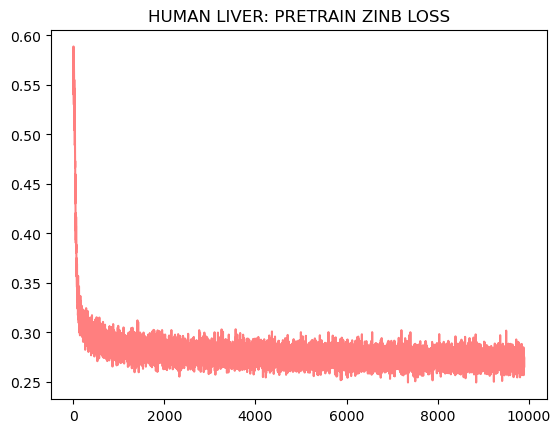

In [77]:
plt.plot(pre_loss, color = 'r', alpha = 0.5)
plt.title('HUMAN LIVER: PRETRAIN ZINB LOSS')

In [78]:
fit_loss['gmm'] = [i.detach().numpy() for i in fit_loss['gmm']]
fit_loss['zinb'] = [i.detach().numpy() for i in fit_loss['zinb']]

Text(0.5, 1.0, 'HUMAN LIVER: FIT ZINB LOSS')

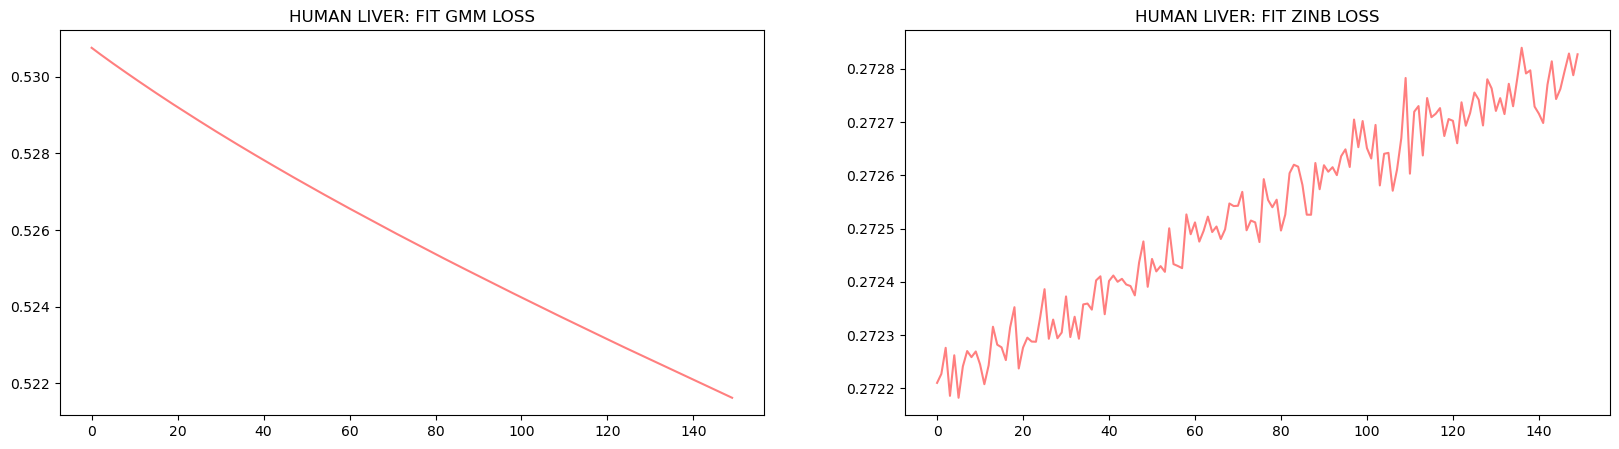

In [79]:
fig, axes  = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5)) 

axes[0].plot(fit_loss['gmm'], color = 'r', alpha = 0.5)
axes[0].set_title('HUMAN LIVER: FIT GMM LOSS')

axes[1].plot(fit_loss['zinb'], color = 'r', alpha = 0.5)
axes[1].set_title('HUMAN LIVER: FIT ZINB LOSS')

Text(0.5, 1.0, 'HUMAN LIVER: FIT ARI')

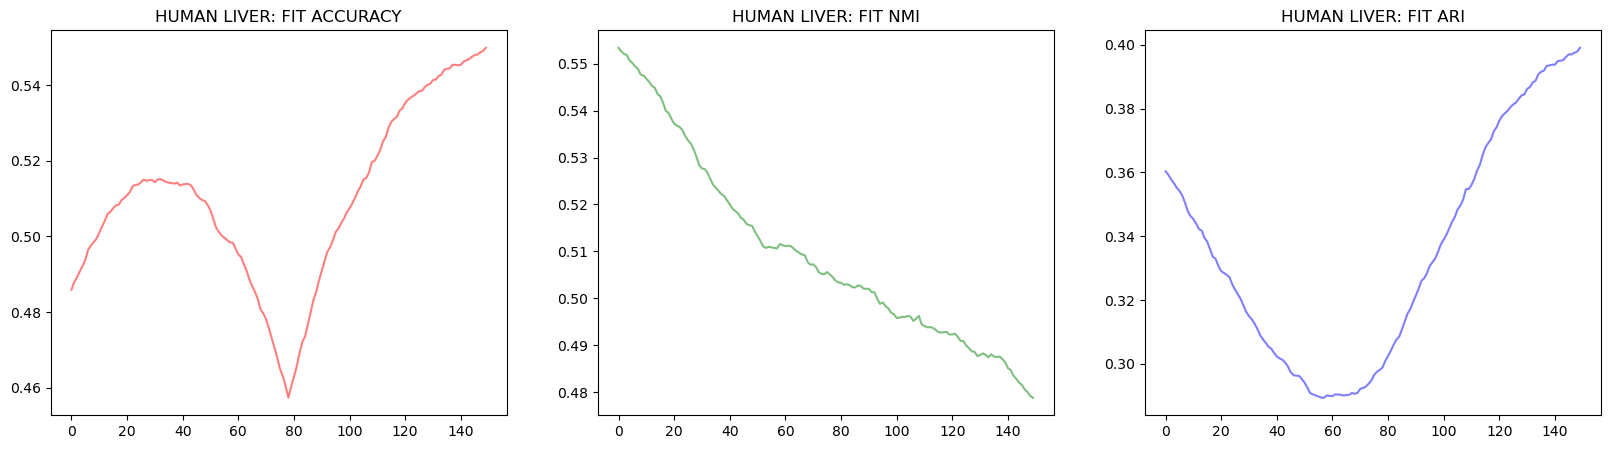

In [80]:
fig, axes  = plt.subplots(nrows = 1, ncols = 3, figsize = (20,5)) 
axes[0].plot(clustering_metrics['ac'], color = 'r', alpha = 0.5)
axes[0].set_title('HUMAN LIVER: FIT ACCURACY')

axes[1].plot(clustering_metrics['nmi'], color = 'g', alpha = 0.5)
axes[1].set_title('HUMAN LIVER: FIT NMI')

axes[2].plot(clustering_metrics['ari'], color = 'b', alpha = 0.5)
axes[2].set_title('HUMAN LIVER: FIT ARI')

## 10x_PBMC

In [81]:
path = 'results/10x_PBMC_06_04/'
pre_loss = pickle.load(open(path + 'pretrain_loss.pickle', 'rb'))
fit_loss = pickle.load(open(path + 'losses.pickle', 'rb'))
clustering_metrics =  pickle.load(open(path + 'clustering_metrics.pickle', 'rb'))
clustering_metrics_id =  pickle.load(open(path + 'clustering_metrics_id.pickle', 'rb'))

Text(0.5, 1.0, '10x_PBMC: PRETRAIN ZINB LOSS')

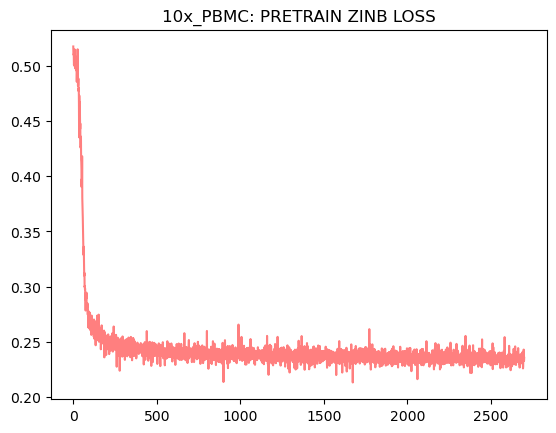

In [82]:
plt.plot(pre_loss, color = 'r', alpha = 0.5)
plt.title('10x_PBMC: PRETRAIN ZINB LOSS')

In [83]:
fit_loss['gmm'] = [i.detach().numpy() for i in fit_loss['gmm']]
fit_loss['zinb'] = [i.detach().numpy() for i in fit_loss['zinb']]

Text(0.5, 1.0, '10x_PBMC: FIT ZINB LOSS')

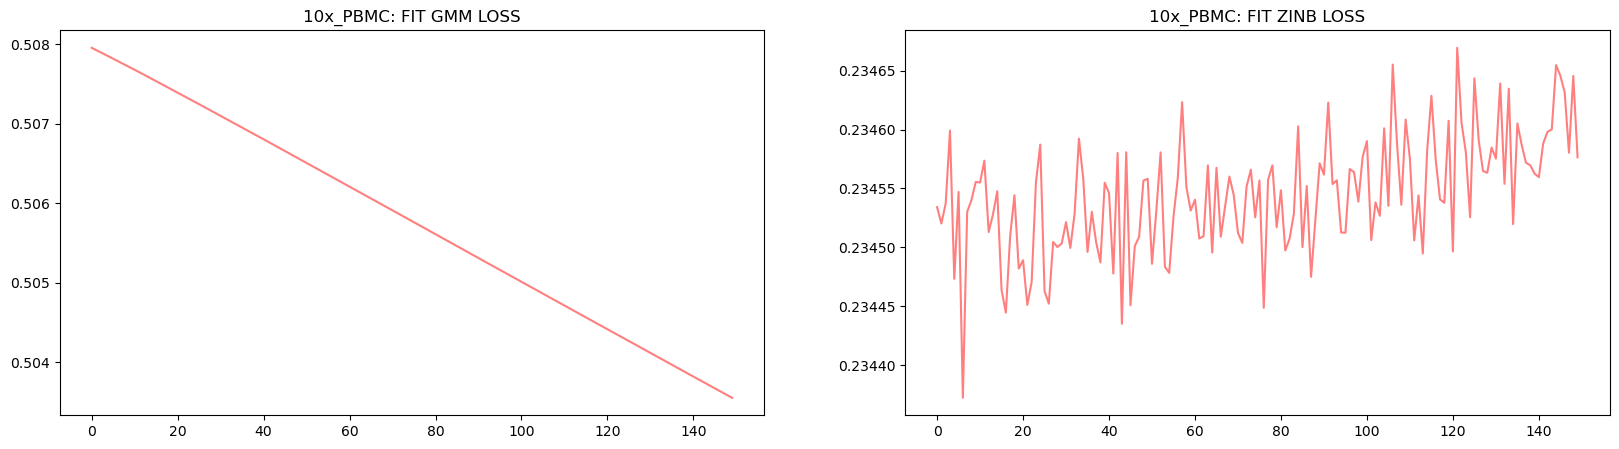

In [86]:
fig, axes  = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5)) 

axes[0].plot(fit_loss['gmm'], color = 'r', alpha = 0.5)
axes[0].set_title('10x_PBMC: FIT GMM LOSS')

axes[1].plot(fit_loss['zinb'], color = 'r', alpha = 0.5)
axes[1].set_title('10x_PBMC: FIT ZINB LOSS')

Text(0.5, 1.0, '10x_PBMC: FIT ARI')

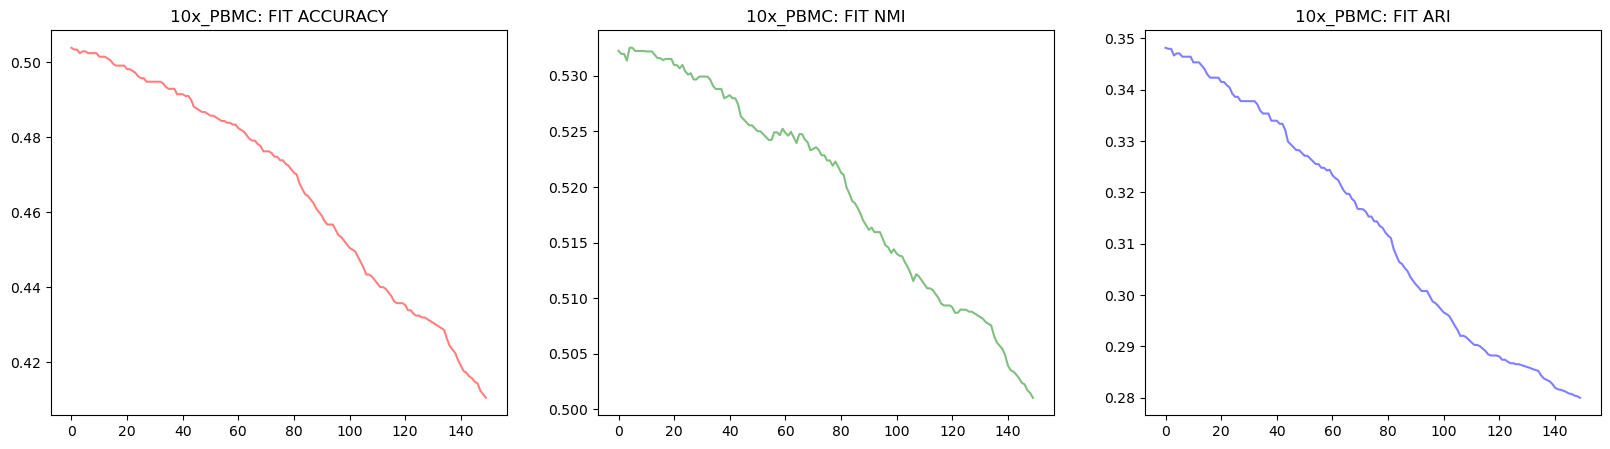

In [87]:
fig, axes  = plt.subplots(nrows = 1, ncols = 3, figsize = (20,5)) 
axes[0].plot(clustering_metrics['ac'], color = 'r', alpha = 0.5)
axes[0].set_title('10x_PBMC: FIT ACCURACY')

axes[1].plot(clustering_metrics['nmi'], color = 'g', alpha = 0.5)
axes[1].set_title('10x_PBMC: FIT NMI')

axes[2].plot(clustering_metrics['ari'], color = 'b', alpha = 0.5)
axes[2].set_title('10x_PBMC: FIT ARI')

Text(0.5, 1.0, '10x_PBMC: FIT ARI (ID as cov)')

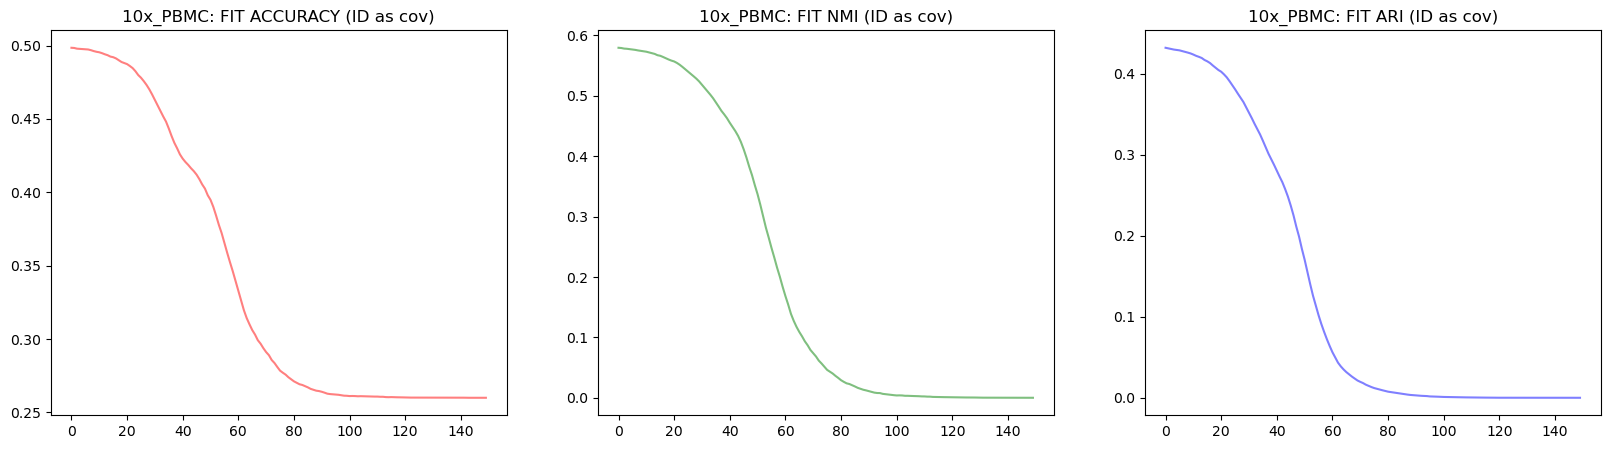

In [98]:
fig, axes  = plt.subplots(nrows = 1, ncols = 3, figsize = (20,5)) 
axes[0].plot(clustering_metrics_id['ac'], color = 'r', alpha = 0.5)
axes[0].set_title('10x_PBMC: FIT ACCURACY (ID as cov)')

axes[1].plot(clustering_metrics_id['nmi'], color = 'g', alpha = 0.5)
axes[1].set_title('10x_PBMC: FIT NMI (ID as cov)')

axes[2].plot(clustering_metrics_id['ari'], color = 'b', alpha = 0.5)
axes[2].set_title('10x_PBMC: FIT ARI (ID as cov)')

## Macosko

In [88]:
path = 'results/Mocosko_mouse_retina_06_04/'
pre_loss = pickle.load(open(path + 'pretrain_loss.pickle', 'rb'))
fit_loss = pickle.load(open(path + 'losses.pickle', 'rb'))
clustering_metrics =  pickle.load(open(path + 'clustering_metrics.pickle', 'rb'))
clustering_metrics_id =  pickle.load(open(path + 'clustering_metrics_id.pickle', 'rb'))

Text(0.5, 1.0, 'Macosko: PRETRAIN ZINB LOSS')

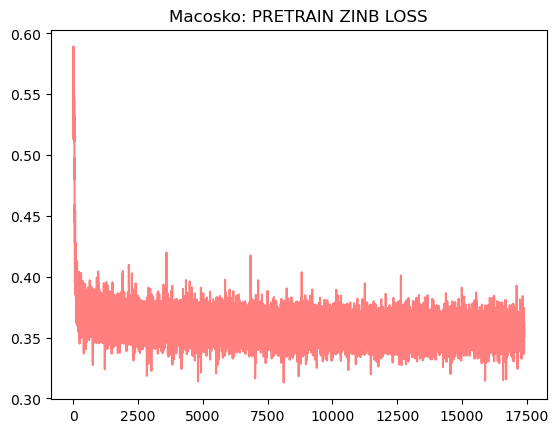

In [89]:
plt.plot(pre_loss, color = 'r', alpha = 0.5)
plt.title('Macosko: PRETRAIN ZINB LOSS')

In [90]:
fit_loss['gmm'] = [i.detach().numpy() for i in fit_loss['gmm']]
fit_loss['zinb'] = [i.detach().numpy() for i in fit_loss['zinb']]

Text(0.5, 1.0, 'Macosko: FIT ZINB LOSS')

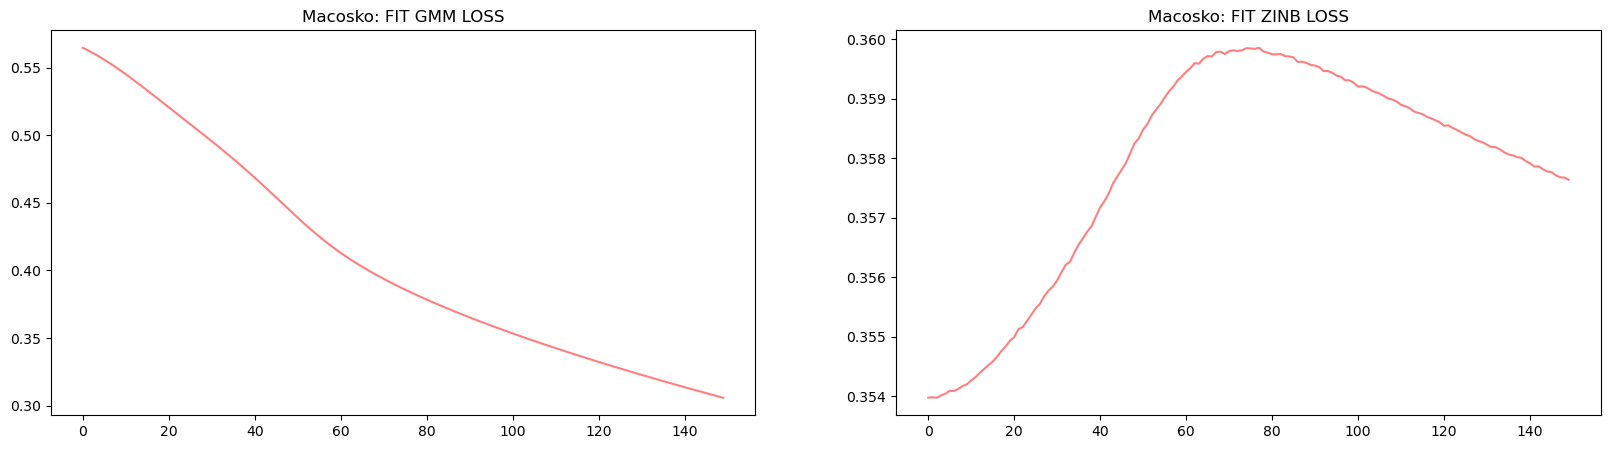

In [91]:
fig, axes  = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5)) 

axes[0].plot(fit_loss['gmm'], color = 'r', alpha = 0.5)
axes[0].set_title('Macosko: FIT GMM LOSS')

axes[1].plot(fit_loss['zinb'], color = 'r', alpha = 0.5)
axes[1].set_title('Macosko: FIT ZINB LOSS')

Text(0.5, 1.0, 'Macosko: FIT ARI')

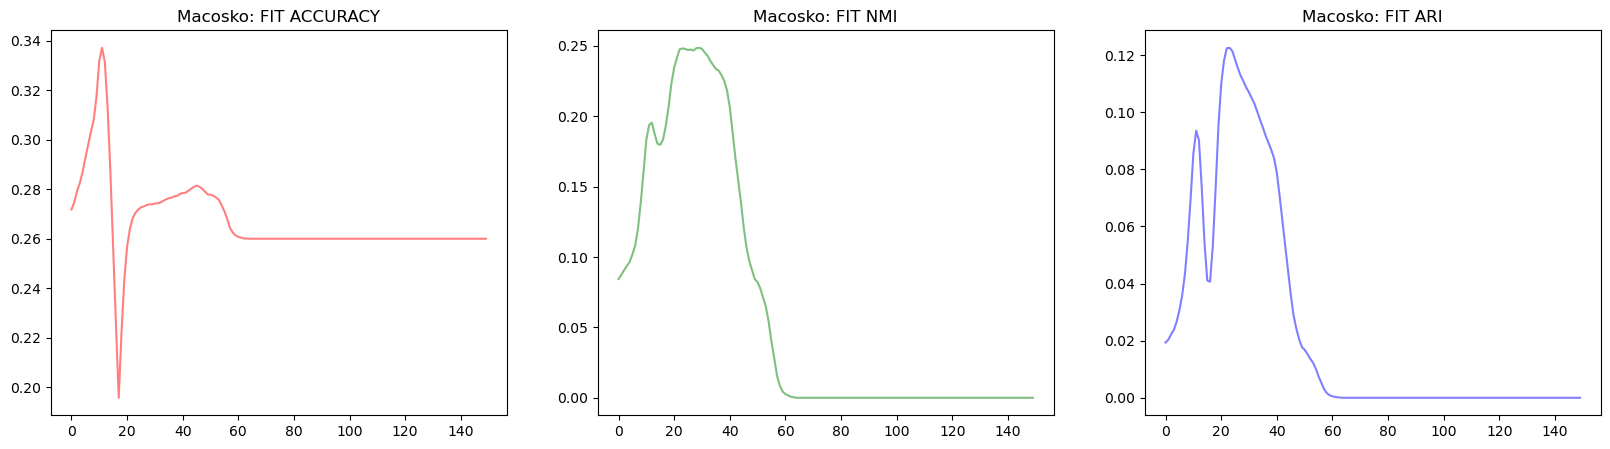

In [92]:
fig, axes  = plt.subplots(nrows = 1, ncols = 3, figsize = (20,5)) 
axes[0].plot(clustering_metrics['ac'], color = 'r', alpha = 0.5)
axes[0].set_title('Macosko: FIT ACCURACY')

axes[1].plot(clustering_metrics['nmi'], color = 'g', alpha = 0.5)
axes[1].set_title('Macosko: FIT NMI')

axes[2].plot(clustering_metrics['ari'], color = 'b', alpha = 0.5)
axes[2].set_title('Macosko: FIT ARI')